In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from datasets import Dataset, load_dataset
import tensorflow as tf
import keras

from transformers import TFAutoModel


from sklearn.preprocessing import LabelEncoder
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import TFAutoModelForSequenceClassification 
from sklearn.metrics import accuracy_score, f1_score



In [3]:
datasets = {}
for dirname, _, filenames in os.walk('./raw_data/twitter_emotion/'):
    for filename in filenames:
        filename_title = filename.split('.txt')[0]
        filename_path = os.path.join(dirname, filename)
        datasets[filename_title] = filename_path
        print(filename_path)

./raw_data/twitter_emotion/test.txt
./raw_data/twitter_emotion/train.txt
./raw_data/twitter_emotion/val.txt


In [4]:
datasets

{'test': './raw_data/twitter_emotion/test.txt',
 'train': './raw_data/twitter_emotion/train.txt',
 'val': './raw_data/twitter_emotion/val.txt'}

# **Load the Data for Visualization**

In [5]:
train_ds = pd.read_csv(datasets['train'], delimiter=";", names=["text", "label"])

val_ds = pd.read_csv(datasets['val'], delimiter=";", names=["text", "label"])

test_ds = pd.read_csv(datasets['test'], delimiter=";", names=["text", "label"])

In [6]:
train_ds

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [7]:
val_ds

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [8]:
test_ds

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


# **Visualize Data**

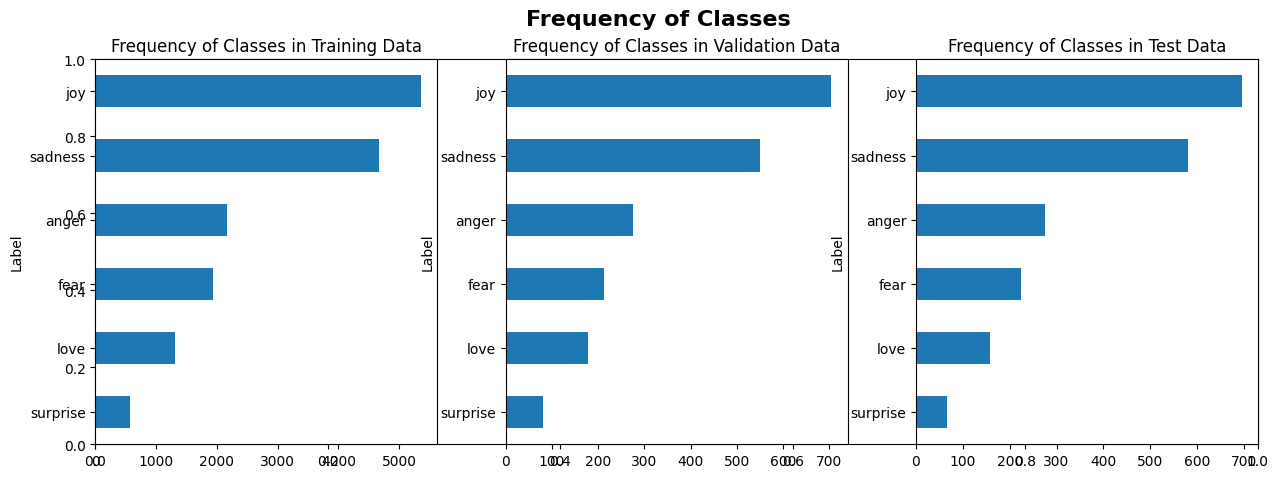

In [9]:
plt.subplots(figsize=(15,5))

plt.subplot(1,3,1)
train_ds["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in Training Data")
plt.ylabel("Label")

plt.subplot(1,3,2)
val_ds["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in Validation Data")
plt.ylabel("Label")

plt.subplot(1,3,3)
test_ds["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in Test Data")
plt.ylabel("Label")

plt.suptitle("Frequency of Classes", fontsize=16, fontweight='bold')
plt.show()


In [10]:
# Concat Train and Val Set to get a better overview of whole Training Set

emotions = pd.concat([train_ds, val_ds], axis=0)

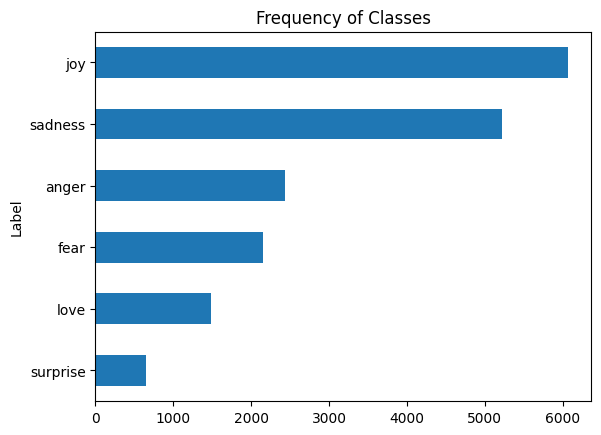

In [11]:
emotions["label"].value_counts(ascending=True).plot.barh()
plt.ylabel("Label")
plt.title("Frequency of Classes")
plt.show()

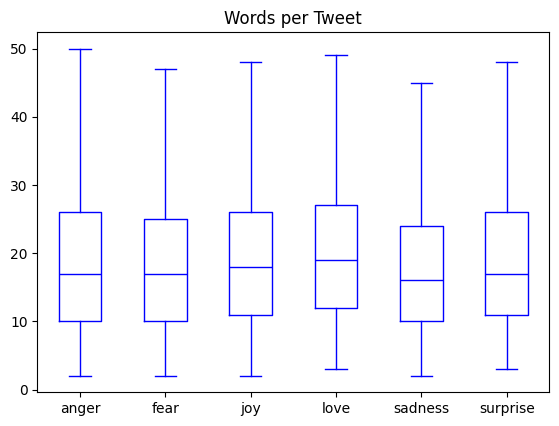

In [12]:
emotions["Words per Tweet"] = emotions["text"].str.split().apply(len)
emotions.boxplot("Words per Tweet", by="label", grid=False, showfliers=False, color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show()

Loading Datasets again but this time as a Dict

In [13]:
emotions_train = load_dataset("csv", data_files=datasets['train'], delimiter=";", names=["text", "label"])
emotions_val = load_dataset("csv", data_files=datasets['val'], delimiter=";", names=["text", "label"])
emotions_test = load_dataset("csv", data_files=datasets['test'], delimiter=";", names=["text", "label"])

In [14]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [15]:
emotions_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [16]:
emotions_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# **Import pre-trained Model DistilBERT**

In [17]:
from transformers import AutoTokenizer

model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

# **Tokenization**

In [18]:
def tokenize(data):
    #train_texts = data["text"].tolist()
    return tokenizer(data["text"], padding=True, truncation=True, return_tensors="tf")

In [19]:
emotions_train_encoded = emotions_train.map(tokenize, batched = True, batch_size = None) # token encodings train set

emotions_val_encoded = emotions_val.map(tokenize, batched = True, batch_size = None) # token encodings validation set

In [20]:
emotions_train_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
})

In [21]:
emotions_val_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# **Train Model on Twitter Dataset**

**1. Feature Extraction**

In [22]:
bert_model = TFAutoModel.from_pretrained(model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [23]:
# Get hidden States for Feature Extraction 

def extract_hidden_states(batch):
    #inputs = {key: tf.convert_to_tensor(batch[key]) for key in batch.keys() if key != "label"}
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    outputs = bert_model(inputs)
    hidden_states = outputs.last_hidden_state[:, 0].numpy()
    return {"hidden_states": hidden_states}

train_hidden_states = emotions_train_encoded.map(extract_hidden_states, batched=True)
val_hidden_states = emotions_val_encoded.map(extract_hidden_states, batched=True) 

c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
train_hidden_states

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_states'],
        num_rows: 16000
    })
})

In [25]:
val_hidden_states

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_states'],
        num_rows: 2000
    })
})

In [26]:
X_train = np.array(train_hidden_states["train"]["hidden_states"])
X_val = np.array(val_hidden_states["train"]["hidden_states"])

In [27]:
y_train = np.array(train_hidden_states["train"]["label"])
y_val = np.array(val_hidden_states["train"]["label"])

In [28]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)

In [29]:
# Visualize the Training Set in a 2D 

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.471747,6.244782,4
1,-2.975345,5.657797,4
2,5.397854,2.779489,0
3,-2.201966,3.185309,3
4,-2.956764,3.716948,0


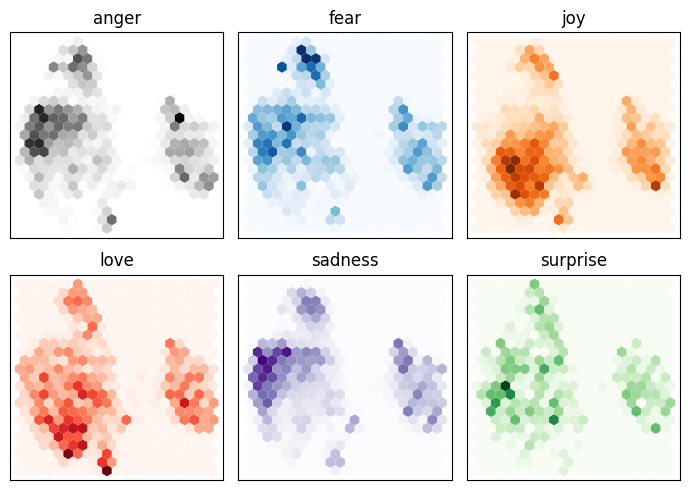

In [30]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = np.unique(emotions_train["train"]["label"])


for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label=={i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                  gridsize=20, linewidth=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

Using some base Models 

In [31]:
xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)

xgb_clf.score(X_val, y_val)

0.59

In [32]:
log_clf = LogisticRegression(max_iter=3000)

log_clf.fit(X_train, y_train)

log_clf.score(X_val, y_val)

0.6345

****Evaluation****

In [33]:
model1 = "XGBoost Classifier"
model2 = "Logistic Regression"

def confusion_matrix_plot(y_pred, y_true, labels, clf):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    confm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    confm.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title(f"Normalized confusion matrix {clf}")
    plt.show()

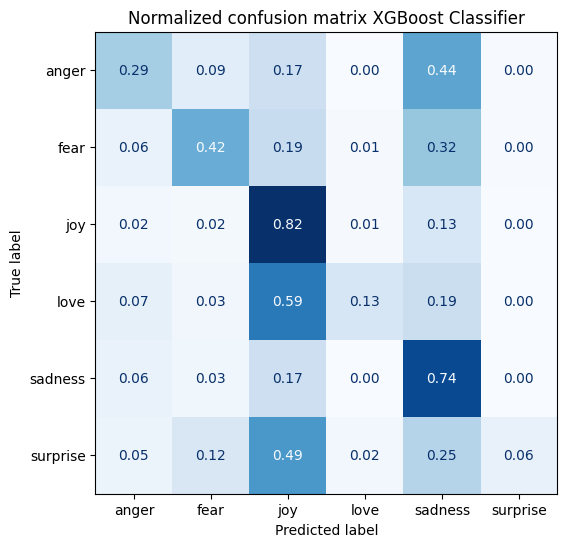

In [34]:
# XGB Classifier Confusion Matrix

y_pred_xgb = xgb_clf.predict(X_val)
confusion_matrix_plot(y_pred_xgb, y_val, labels, model1)

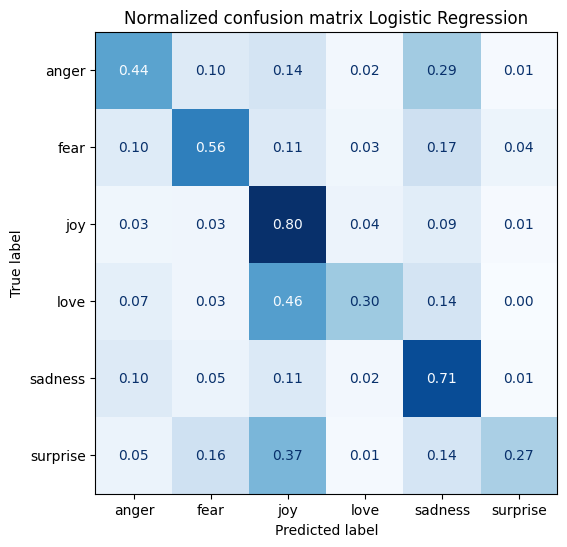

In [35]:
# Logistic Regression Confusion Matrix

y_pred_log = log_clf.predict(X_val)
confusion_matrix_plot(y_pred_log, y_val, labels, model2)

**2. Fine-Tuning**

In [36]:
num_labels = 6 
batch_size = 64
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model, num_labels=num_labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [37]:
# Label Encoding for TF Model
labels_train = emotions_train_encoded["train"]["label"]
labels_val = emotions_val_encoded["train"]["label"]

label_encoded_train = le.fit_transform(labels_train)
emotions_train_encoded["train"] = emotions_train_encoded["train"].add_column("encoded_label", label_encoded_train)

label_encoded_val = le.fit_transform(labels_val)
emotions_val_encoded["train"] = emotions_val_encoded["train"].add_column("encoded_label", label_encoded_val)

In [38]:
tokenizer_columns = tokenizer.model_input_names 

tf_train =  emotions_train_encoded["train"].to_tf_dataset(columns=tokenizer_columns, label_cols=["encoded_label"], 
                                                          shuffle=True, 
                                                          batch_size=batch_size)

tf_val = emotions_val_encoded["train"].to_tf_dataset(columns=tokenizer_columns, label_cols=["encoded_label"], 
                                                     shuffle=False, 
                                                     batch_size=batch_size)

c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\datasets\arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [39]:
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [40]:
tf_model.fit(tf_train, validation_data=tf_val, epochs=3)

Epoch 1/3
250/250 [==============================] - 1532s 6s/step - loss: 0.5014 - sparse_categorical_accuracy: 0.8286 - val_loss: 0.1727 - val_sparse_categorical_accuracy: 0.9310
Epoch 2/3
250/250 [==============================] - 1727s 7s/step - loss: 0.1371 - sparse_categorical_accuracy: 0.9416 - val_loss: 0.1362 - val_sparse_categorical_accuracy: 0.9360
Epoch 3/3
250/250 [==============================] - 1687s 7s/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.1398 - val_sparse_categorical_accuracy: 0.9350


In [46]:
type(tf_model)

transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification

In [50]:
# NOTE: Not sure if this is loadable, but I tried!
# tf_model.save(filepath='model', save_format="tf")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [47]:
type(tf_val)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [51]:
tf_val

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 69), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 69), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [41]:
y_pred_tf = tf_model.predict(tf_val)

32/32 [==============================] - 59s 2s/step


In [45]:
type(y_pred_tf)

transformers.modeling_tf_outputs.TFSequenceClassifierOutput

In [52]:
y_pred_tf

TFSequenceClassifierOutput(loss=None, logits=array([[-1.8863364 , -1.9406531 , -1.8192376 , -1.4573977 ,  6.3472066 ,
        -2.5579407 ],
       [-1.4492514 , -1.5728852 , -1.4325237 , -2.600792  ,  6.5150146 ,
        -2.7778215 ],
       [-2.5226693 , -2.7436476 ,  3.6829553 ,  3.6134374 , -2.3469472 ,
        -2.843709  ],
       ...,
       [-1.5783063 , -2.1110277 ,  6.723463  , -1.6521782 , -2.0448577 ,
        -1.8331978 ],
       [-2.2215636 , -2.8450391 ,  4.168122  ,  3.3221743 , -2.5009034 ,
        -3.0605054 ],
       [-2.5076964 , -1.8632717 ,  6.692193  , -1.9211462 , -2.1586626 ,
        -0.82009965]], dtype=float32), hidden_states=None, attentions=None)

In [43]:
# Predictet Labels from Model

logits = y_pred_tf.logits
y_pred = np.argmax(logits, axis=1)

print("Predicted Labels:", y_pred)

Predicted Labels: [4 4 2 ... 2 2 2]


In [44]:
# Get true Labels

def extract_labels(features, labels):
    return labels

y_true = tf_val.map(extract_labels)

y_true = tf.concat(list(y_true.as_numpy_iterator()), axis=0)
print(y_true)

tf.Tensor([4 4 3 ... 2 2 2], shape=(2000,), dtype=int64)


# Predicting Emotion Label on Lyrics

In [55]:
lyrics_test_data = load_dataset("csv", data_files='./lyrics_text.csv', delimiter=",", names=["text"]) # Might have to amend the delimiter, based on how we write the data, and will the test break if I don't have labels? 

Generating train split: 0 examples [00:00, ? examples/s]

In [56]:
lyrics_test_data

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 28372
    })
})

In [57]:
lyrics_test_encoded = lyrics_test_data.map(tokenize, batched = True, batch_size = None) # token encodings validation set

Map:   0%|          | 0/28372 [00:00<?, ? examples/s]

In [58]:
lyrics_test_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 28372
    })
})

In [53]:
tokenizer_columns

['input_ids', 'attention_mask']

In [59]:
tokenizer_columns= tokenizer.model_input_names 

# tf_lyrics is supposed to map to tf_val. Hopefully, I should be able to use it in a very similar way. 
tf_lyrics = lyrics_test_encoded["train"].to_tf_dataset(columns=tokenizer_columns, # label_cols=["encoded_label"], 
                                                     shuffle=False, 
                                                     batch_size=batch_size)

In [60]:
lyrics_y_pred_tf = tf_model.predict(tf_lyrics)

InvalidArgumentError: Graph execution error:

Detected at node 'tf_distil_bert_for_sequence_classification/distilbert/embeddings/Gather_1' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Leen\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever
      self._run_once()
    File "C:\Users\Leen\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1936, in _run_once
      handle._run()
    File "C:\Users\Leen\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 84, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Leen\AppData\Local\Temp\ipykernel_3272\2089678967.py", line 1, in <module>
      lyrics_y_pred_tf = tf_model.predict(tf_lyrics)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\modeling_tf_utils.py", line 1249, in predict
      return super().predict(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\modeling_tf_utils.py", line 805, in run_call_with_unpacked_inputs
      # Read the H5 file
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 813, in call
      distilbert_output = self.distilbert(
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\modeling_tf_utils.py", line 805, in run_call_with_unpacked_inputs
      # Read the H5 file
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 458, in call
      embedding_output = self.embeddings(input_ids, inputs_embeds=inputs_embeds)  # (bs, seq_length, dim)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 121, in call
      position_embeds = tf.gather(params=self.position_embeddings, indices=position_ids)
Node: 'tf_distil_bert_for_sequence_classification/distilbert/embeddings/Gather_1'
indices[0,558] = 558 is not in [0, 512)
	 [[{{node tf_distil_bert_for_sequence_classification/distilbert/embeddings/Gather_1}}]] [Op:__inference_predict_function_67489]

In [ ]:
# NOTE: Code from ChatGPT, it's supposed to ensure that the number of tokens doesn't surpass DistilBert's maximum. 

# from transformers import DistilBertTokenizer

# # Load DistilBERT tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Function to calculate sequence length and truncate sequences if necessary
# def preprocess_text(text, max_length=512):
#     # Tokenize text
#     tokenized_text = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    
#     # Check sequence length
#     sequence_length = tokenized_text.input_ids.size(1)
    
#     # Truncate sequences if necessary
#     if sequence_length > max_length:
#         # Truncate from the beginning, you can also truncate from the end or both sides
#         truncated_text = tokenized_text[:, -(max_length):]
#     else:
#         truncated_text = tokenized_text
    
#     return truncated_text

# # Example lyrics text
# lyrics_text = "Your lyrics here"

# # Preprocess text
# preprocessed_text = preprocess_text(lyrics_text)

# # Print sequence length
# print("Sequence length:", preprocessed_text.input_ids.size(1))


**Evaluation**

In [44]:
# Metrics which we use to evaluate the model



def evaluate_model(y_true, y_prediction):
    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)
    return {"accuarcy": acc, "f1": f1}

In [45]:
evaluate_model(y_true, y_pred)

{'accuarcy': 0.9325, 'f1': 0.9323222677629223}

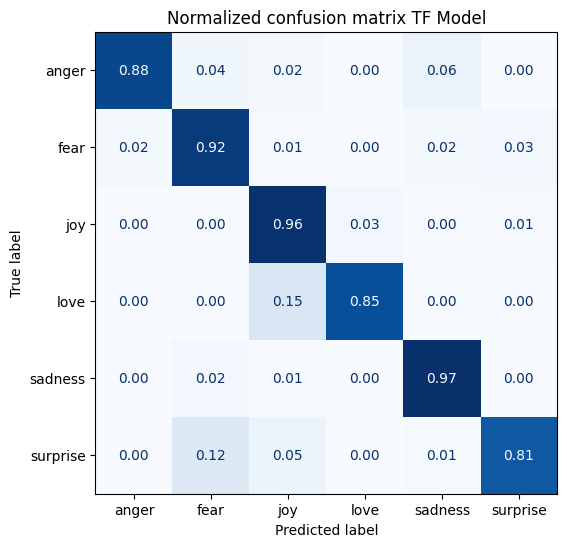

In [46]:
# Confusion Matrix

confusion_matrix_plot(y_pred, y_true, labels, "TF Model")


In [47]:
# Display some examples

for i in range(20):
    predicted_label_index = y_pred[i]
    predicted_label = emotions_train["train"]["label"][predicted_label_index]
    true_label_index = int(y_true[i])
    true_label = le.inverse_transform([true_label_index])

    print(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}\nText: {emotions_val_encoded['train']['text'][i]}\n\n")
    

Predicted Label: anger
True Label: ['sadness']
Text: im feeling quite sad and sorry for myself but ill snap out of it soon


Predicted Label: anger
True Label: ['sadness']
Text: i feel like i am still looking at a blank canvas blank pieces of paper


Predicted Label: anger
True Label: ['love']
Text: i feel like a faithful servant


Predicted Label: sadness
True Label: ['anger']
Text: i am just feeling cranky and blue


Predicted Label: anger
True Label: ['joy']
Text: i can have for a treat or if i am feeling festive


Predicted Label: anger
True Label: ['joy']
Text: i start to feel more appreciative of what god has done for me


Predicted Label: anger
True Label: ['joy']
Text: i am feeling more confident that we will be able to take care of this baby


Predicted Label: anger
True Label: ['joy']
Text: i feel incredibly lucky just to be able to talk to her


Predicted Label: anger
True Label: ['joy']
Text: i feel less keen about the army every day


Predicted Label: anger
True Label: ['s